# Basic Approach for Trace Clustering
## Kmeans + One Hot Encoding

Requirements:
- ~~implement basic approach (one-hot-enconding + kmeans)~~
- ~~hyperparameter experiments (grid-search)~~
- ~~interpretation of clusters (one municipal? etc.)~~
- ~~Notebook nicely presenting the clustering results for different hyperparameters~~

In [1]:
from practical.ProcessMining.group1.shared import utils
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.objects.conversion.log import converter as log_converter
from sklearn import metrics
from joblib import Parallel, delayed
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

BASE = utils.SAMPLES_PATH
real_path = BASE / "DomesticDeclarations_cleansed.csv"
event_log_raw = utils.import_csv(BASE / "DomesticDeclarations_cleansed.csv")

In [2]:
def get_activities(log):
    return list(log['concept:name'].unique())

def get_df_by_traces(log):
    return log.groupby('case:concept:name')["concept:name"].apply(list).reset_index()

def hot_encode_traces(traces_df):
    traces = traces_df["concept:name"].to_list()
    all_activities = get_activities(event_log_raw)
    
    # One-hot encode the event log
    one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[all_activities], handle_unknown='ignore')
    one_hot_encoder.fit(np.array(all_activities).reshape(-1, 1))
    
    # Using dictionary comprehension to encode traces
    encoded_traces = [one_hot_encoder.transform(np.array(trace).reshape(-1, 1)).sum(axis=0) for trace in traces]
    
    # Stacking the encoded traces to form a sampled event log
    return np.vstack(encoded_traces)

def custom_metrics(log, _encoded_log, cluster, petri_net, init_marking, final_marking, weights=None):
    if weights is None:
        weights = {"ss": 0.4, "f": 0.25, "p": 0.35}
    
    ss = metrics.silhouette_score(_encoded_log, cluster)
    
    fitness = pm4py.conformance.fitness_alignments(log, petri_net, init_marking, final_marking)["averageFitness"]
    precision = pm4py.conformance.precision_alignments(log, petri_net, init_marking, final_marking)

    return weights["ss"] * ss + weights["f"] * fitness + weights["p"] * precision
    

In [3]:
event_log_sampled = event_log_raw.sample(n=1000)

traces = get_df_by_traces(event_log_sampled)

encoded_log = hot_encode_traces(traces)

In [4]:
# Apply KMeans clustering with hyperparameter tuning
param_grid = {
    'n_clusters': [5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20],
    'max_iter': [100, 200, 300],
}
    
net, init, final = heuristics_miner.apply(event_log_sampled)
score_weights = {"ss": 0.35, "f": 0.25, "p": 0.4}  # {"ss": 0.4, "f": 0.4, "p": 0.2} {"ss": 0.35, "f": 0.5, "p": 0.35}

def evaluate_model(params, _encoded_log):
    _k_means = KMeans(**params, random_state=42)
    _cluster = _k_means.fit_predict(_encoded_log)
    score = custom_metrics(event_log_sampled, _encoded_log, _cluster, net, init, final, score_weights)
    return score, params
        
results = Parallel(n_jobs=-3)(delayed(evaluate_model)(params, encoded_log) for params in ParameterGrid(param_grid))

best_score, best_params = max(results, key=lambda x: x[0])

print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")

aligning log, completed variants :: 100%|██████████| 36/36 [00:00<00:00, 201.26it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 718.46it/s]
aligning log, completed variants :: 100%|██████████| 36/36 [00:00<00:00, 201.23it/s]00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 683.68it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 688.64it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 666.08it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 725.63it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 654.97it/s]
aligning log, completed variants :: 100%|██████████| 36/36 [00:00<00:00, 200.43it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 579

Best Score: 0.9552476193141175
Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 10, 'n_init': 10}


## Observations while implementation
Improvement Steps:
1. pure silhouette score calculation was too time consuming in combination with parameter tuning
2. To improve, used sample logs of actual eventlog and parallelized execution

Best score range: 
- 0.98 - 0.99

Best params: 
- 'init': 'k-means++'
- 'max_iter': 300
- 'n_clusters': 10

Mostly best params
- 'n_init': 10}

Explanation:
- n_clusters: silhouette score calculates cluster affiliation, the more clusters are used, the better silhouette scores can be expected => overfitting problem, the more clusters, the better the score while cluster <= eventlog-unique-activities
- max_iter: probably for sample set size, already after 300 iterations, no more changes
- init: trivial, that k-means++ performance in average better than random


## Apply best parameters to original Event Log

Next, using best parameters found for sample log to cluster the real log and add it as feature to each row of the eventlog

In [5]:
k_means = KMeans(**best_params, random_state=42)
traces = get_df_by_traces(event_log_raw)

encoded_log = hot_encode_traces(traces)
cluster_labels = k_means.fit_predict(encoded_log)

traces['cluster'] = cluster_labels

event_log = event_log_raw.merge(traces[['case:concept:name', 'cluster']], on='case:concept:name', how='left')

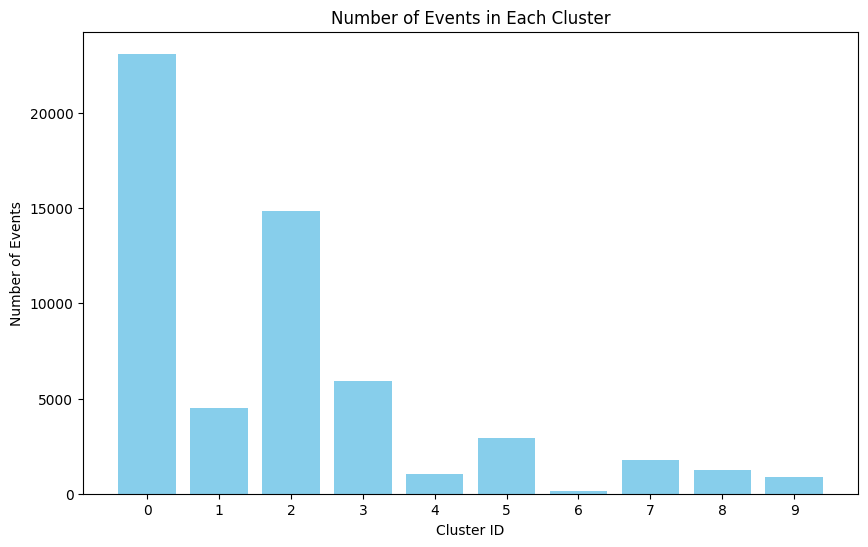

In [6]:
import matplotlib.pyplot as plt

# Split the event log into cluster sublogs
cluster_sublogs = {}
for cluster_label in np.unique(event_log['cluster']):
    cluster_sublogs[cluster_label] = event_log[event_log['cluster'] == cluster_label]

# Plotting the result
cluster_sizes = [len(sublog) for sublog in cluster_sublogs.values()]
plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_sublogs)), cluster_sizes, color='skyblue')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Events')
plt.title('Number of Events in Each Cluster')
plt.xticks(range(len(cluster_sublogs)), labels=cluster_sublogs.keys())
plt.show()

Finally split the modified log by cluster label and save each sublog to a csv file, so that each one can be handled as standalone eventlog

In [7]:
import os

base_dir = "base_approach"
os.makedirs(base_dir, exist_ok=True)

cluster_sublogs = {k: cluster_sublogs[k] for k in sorted(cluster_sublogs)}
for cluster_label, df in cluster_sublogs.items():
    file_path = os.path.join(base_dir, f"cluster_{cluster_label}.csv")
    df.to_csv(file_path,sep=';',index=False)

print(f"Clusters exported to /base_approach")

Clusters exported to /base_approach


## Visualization of Sublogs

To visualize our result, we use pm4py alpha miner and own vizualizer implementation to visualize created sub models

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

Cluster 0: 23114 events, 4623 cases


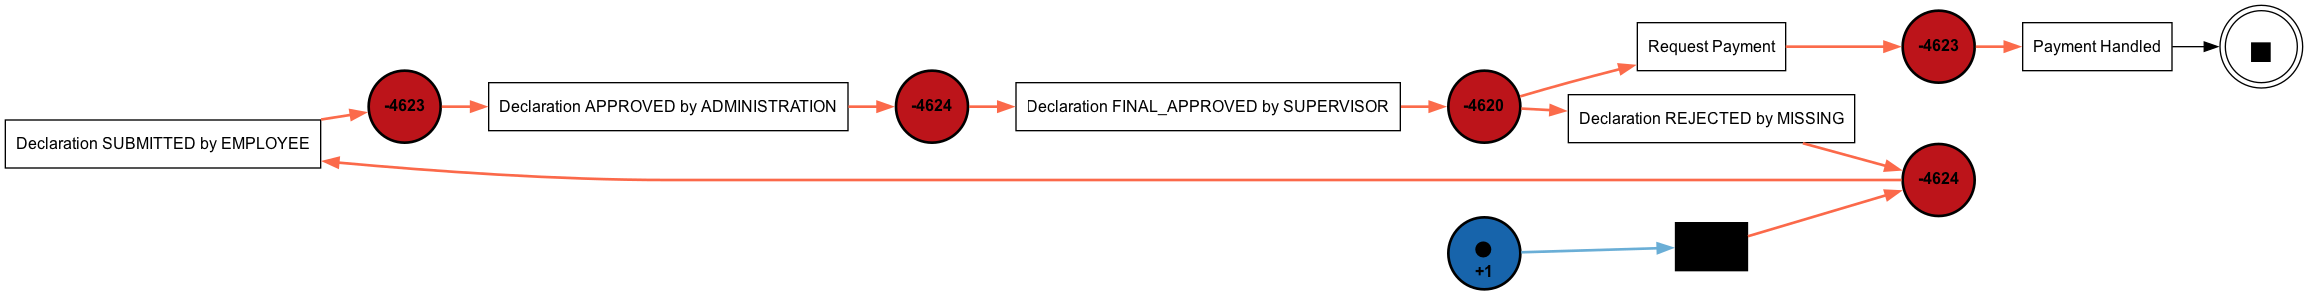

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

Cluster 1: 4491 events, 537 cases


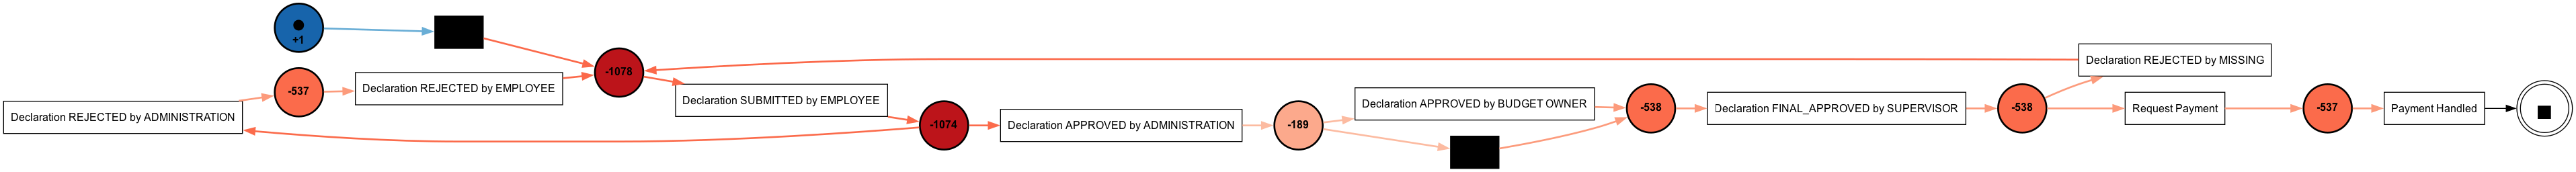

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

Cluster 2: 14858 events, 2476 cases


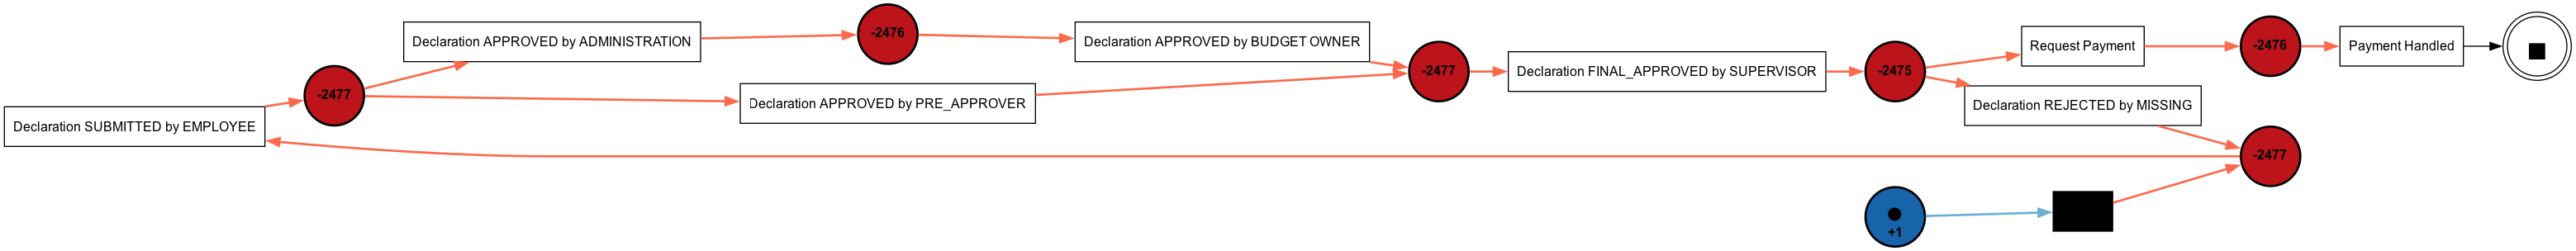

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

Cluster 3: 5934 events, 1458 cases


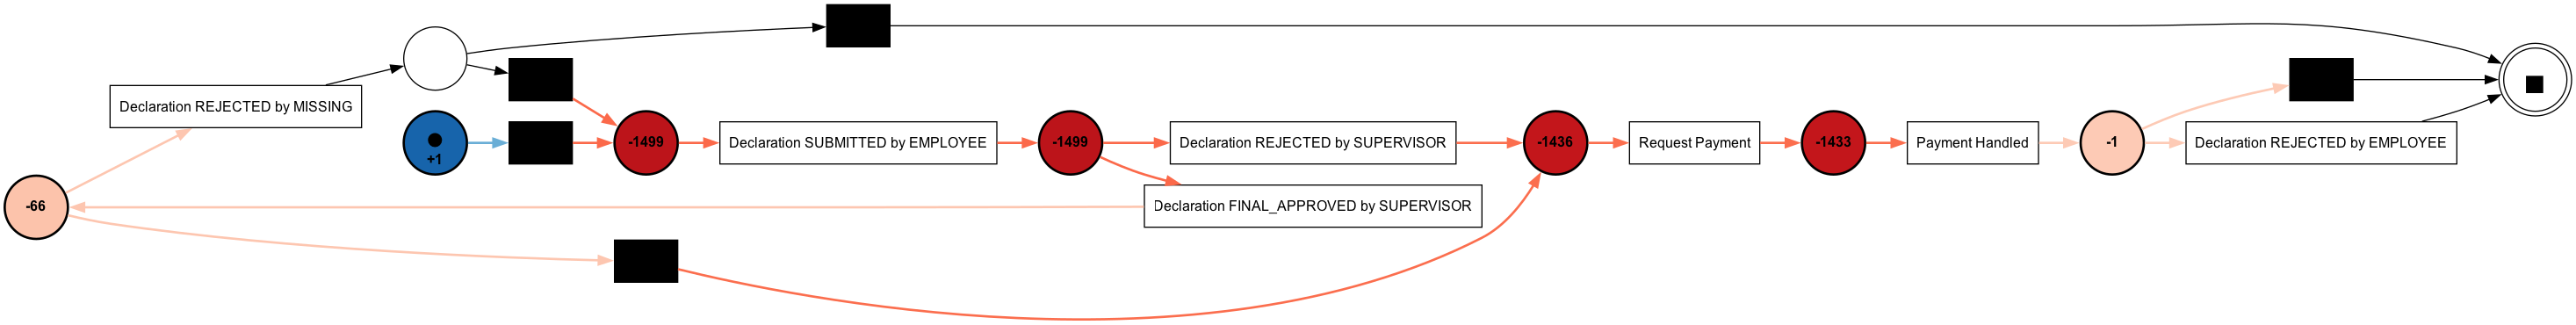

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

Cluster 4: 1028 events, 289 cases


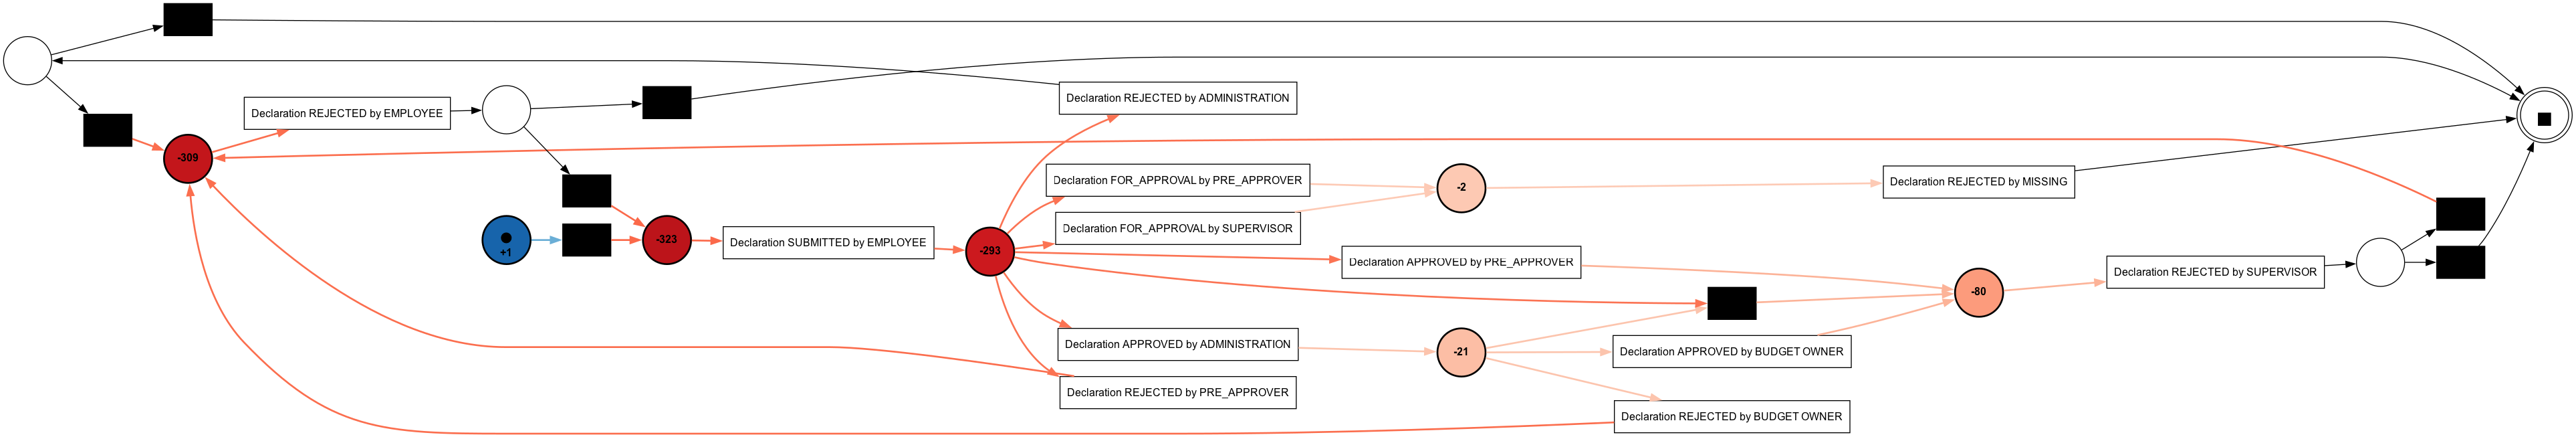

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

Cluster 5: 2946 events, 584 cases


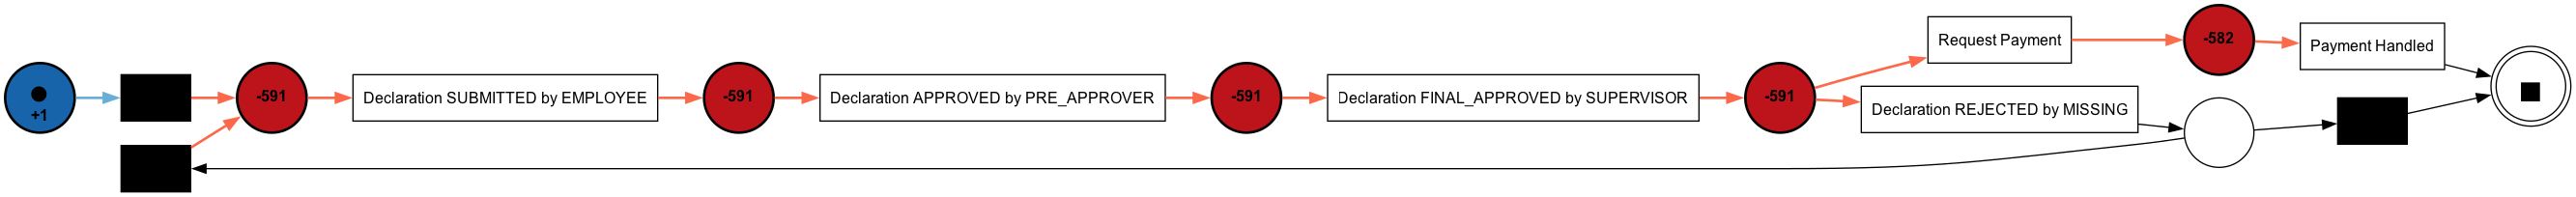

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

Cluster 6: 137 events, 135 cases


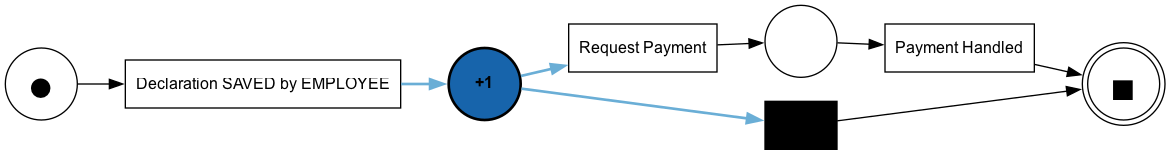

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/70 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Cluster 7: 1793 events, 186 cases


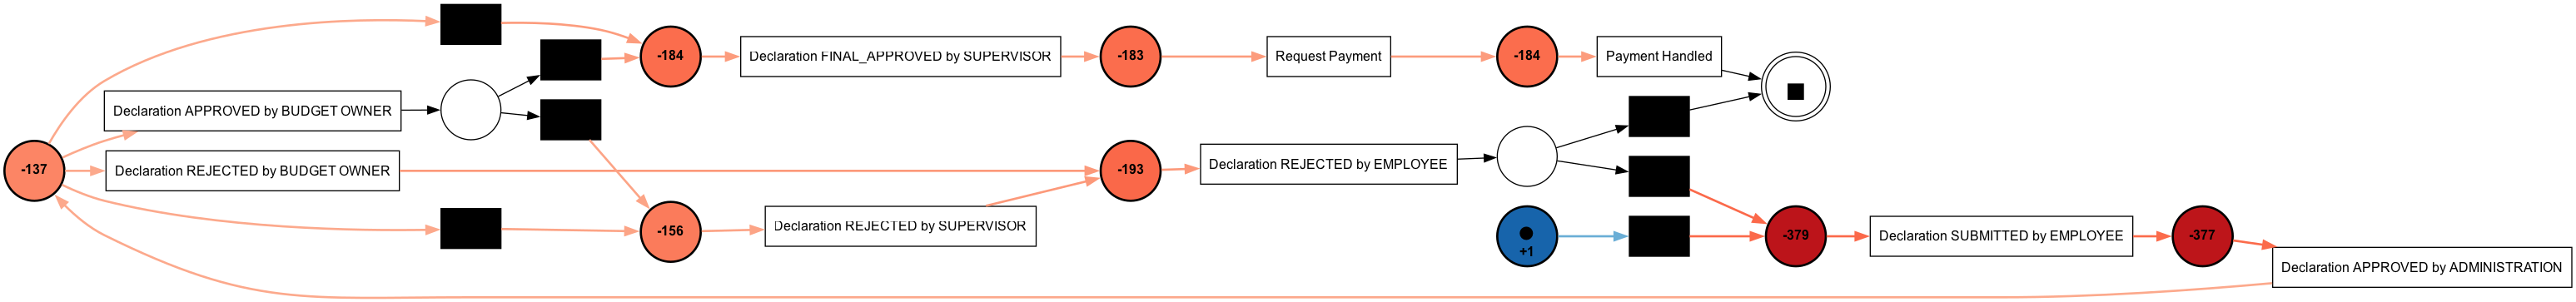

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

Cluster 8: 1232 events, 102 cases


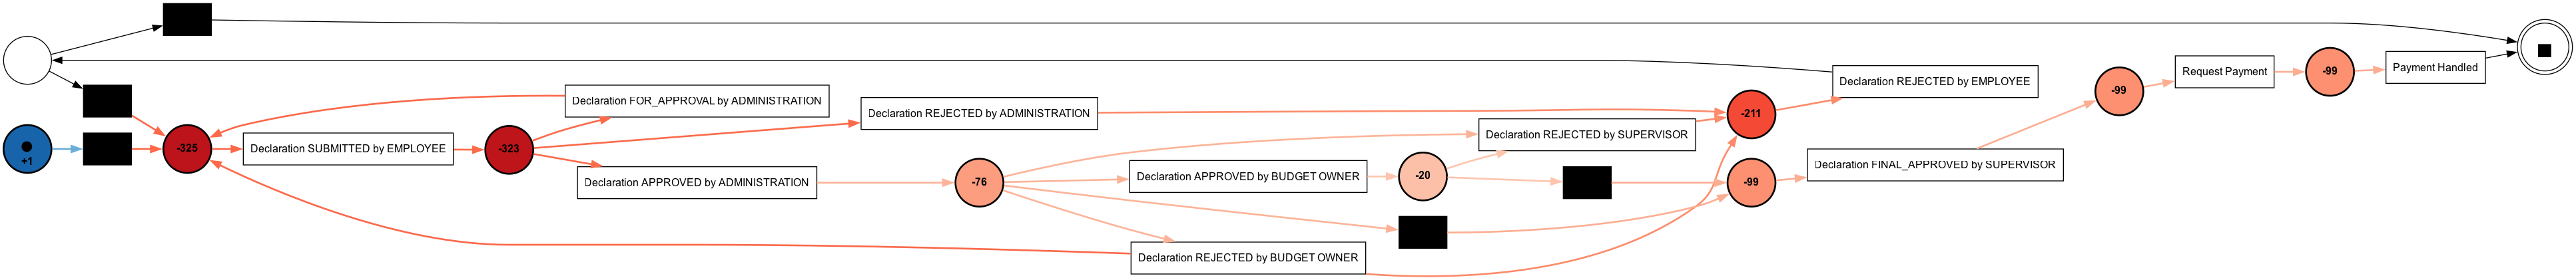

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

Cluster 9: 904 events, 110 cases


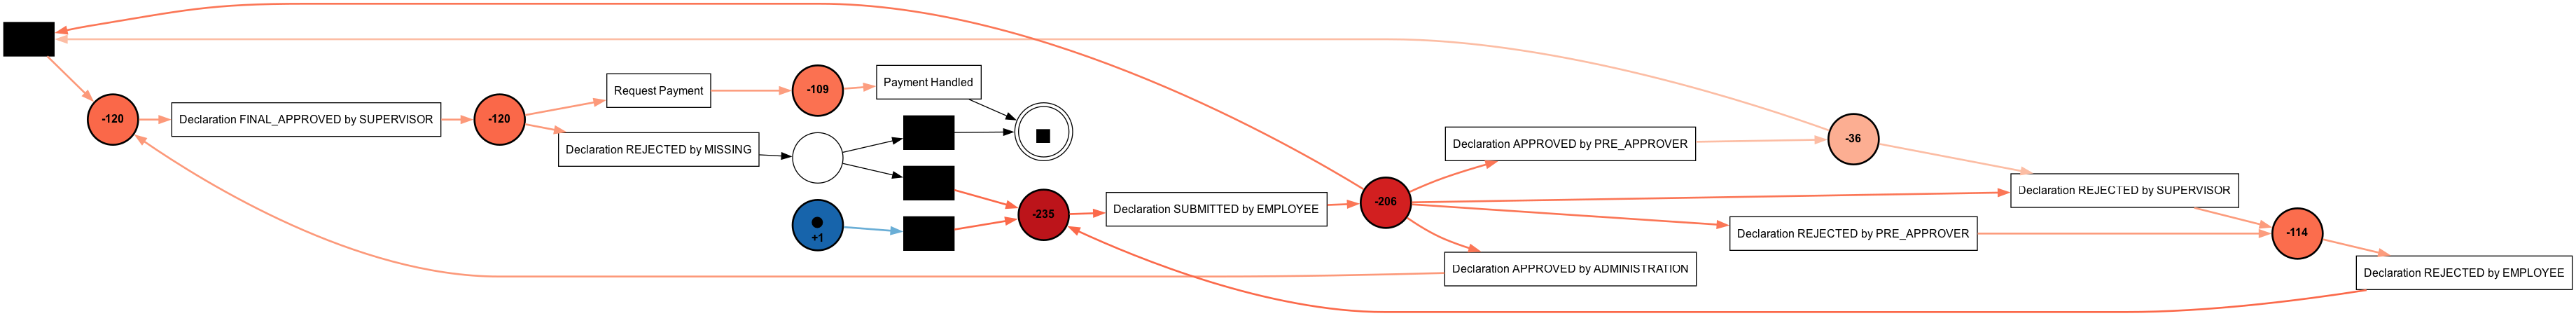

In [8]:
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay

for cluster_label, df in cluster_sublogs.items():   
    event_log = log_converter.to_event_log.apply(df)

    net, init, final = heuristics_miner.apply(event_log)

    heuristics_miner_replay = TokenReplay(event_log, net, init, final, "Heuristic Miner")

    heuristics_miner_replay.run(event_log)  # alpha_token_replay.shuffle_activities()
    tokens = heuristics_miner_replay.get_unconformity_tokens()

    vizard = Visualizer()
    graph = vizard.build_petri_net(net, init, final, tokens)
    print(f'Cluster {cluster_label}: {df.shape[0]} events, {df["case:concept:name"].unique().shape[0]} cases')
    ## print("==== Cluster ", cluster_label, "====")

    vizard.display(graph)